<a href="https://colab.research.google.com/github/sumankmaiti/All-in-one/blob/main/inference_of_vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time


In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super(VGG, self).__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)

        return x, h

""" Next up is calculating the `features` for each VGG configuration."""

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, stride=1, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

"""Now, let's get the `features` for the VGG11 architecture, with batch normalization."""

vgg19_layers = get_vgg_layers(vgg19_config, batch_norm=True)


"""We can then pass these `features` to our base VGG module to get our VGG11 model."""

OUTPUT_DIM = 1000

model = VGG(vgg19_layers, OUTPUT_DIM)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
pretrained_size = [224, 224]
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = nn.DataParallel(model)
model = model.to(device)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/vgg19_imagenet_lr_change.pt'))

In [ ]:
def load_labels(filename="/content/drive/MyDrive/index_to_lebel.txt"):
  labels = {}
  with open(filename, "r") as f:
    lines = f.readlines()
    for line in lines:
      line = line.strip().replace("'","").strip(",")
      # print(line)
      if "{" in line or "}" in line:
        continue
      else:
        idx = int(line.split(":")[0])
        lbl = line.split(":")[1].split(",")
        labels[idx] = [x.strip() for x in lbl]
  return labels
labels = load_labels()
print(labels)

{0: ['tench', 'Tinca tinca'], 1: ['goldfish', 'Carassius auratus'], 2: ['great white shark', 'white shark', 'man-eater', 'man-eating shark', 'Carcharodon carcharias'], 3: ['tiger shark', 'Galeocerdo cuvieri'], 4: ['hammerhead', 'hammerhead shark'], 5: ['electric ray', 'crampfish', 'numbfish', 'torpedo'], 6: ['stingray'], 7: ['cock'], 8: ['hen'], 9: ['ostrich', 'Struthio camelus'], 10: ['brambling', 'Fringilla montifringilla'], 11: ['goldfinch', 'Carduelis carduelis'], 12: ['house finch', 'linnet', 'Carpodacus mexicanus'], 13: ['junco', 'snowbird'], 14: ['indigo bunting', 'indigo finch', 'indigo bird', 'Passerina cyanea'], 15: ['robin', 'American robin', 'Turdus migratorius'], 16: ['bulbul'], 17: ['jay'], 18: ['magpie'], 19: ['chickadee'], 20: ['water ouzel', 'dipper'], 21: ['kite'], 22: ['bald eagle', 'American eagle', 'Haliaeetus leucocephalus'], 23: ['vulture'], 24: ['great grey owl', 'great gray owl', 'Strix nebulosa'], 25: ['European fire salamander', 'Salamandra salamandra'], 26: 

tensor([0.9981], device='cuda:0') tensor([22], device='cuda:0') ['bald eagle', 'American eagle', 'Haliaeetus leucocephalus']


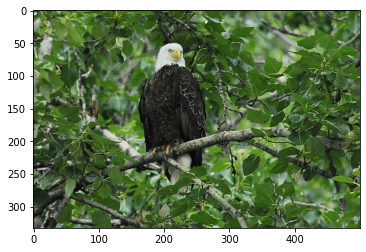

In [ ]:
"""Our test accuracy is a little lower at ~92%, but is still higher than the ~75% achieved by the AlexNet model in the previous tutorial notebook."""
import PIL

image = PIL.Image.open('/content/drive/MyDrive/IMAGENET/Eagle/n01614925_10892.JPEG')
plt.imshow(image)

with torch.no_grad():
  image = test_transforms(image)
  y_pred, _ = model(torch.unsqueeze(image, 0))
  y_prob = F.softmax(y_pred, dim=-1)

prob, ind = y_prob.max(1)
print(prob, ind, labels[int(ind.item())])

['American Staffordshire terrier',
 'Staffordshire terrier',
 'American pit bull terrier',
 'pit bull terrier']